Experimento 1 - ω1: X = 3666.194, Y = 3977.397
Experimento 1 - ω2: X = 3666.194, Y = 3241.411
Experimento 2 - ω1: X = 171795.208, Y = 189429.103
Experimento 2 - ω2: X = 171795.208, Y = 160036.372
Experimento 3 - ω1: X = 4419.107, Y = 8285.384
Experimento 3 - ω2: X = 4419.107, Y = 4279.452
Experimento 4 - ω1: X = 283757.277, Y = 314930.668
Experimento 4 - ω2: X = 283757.277, Y = 309197.120


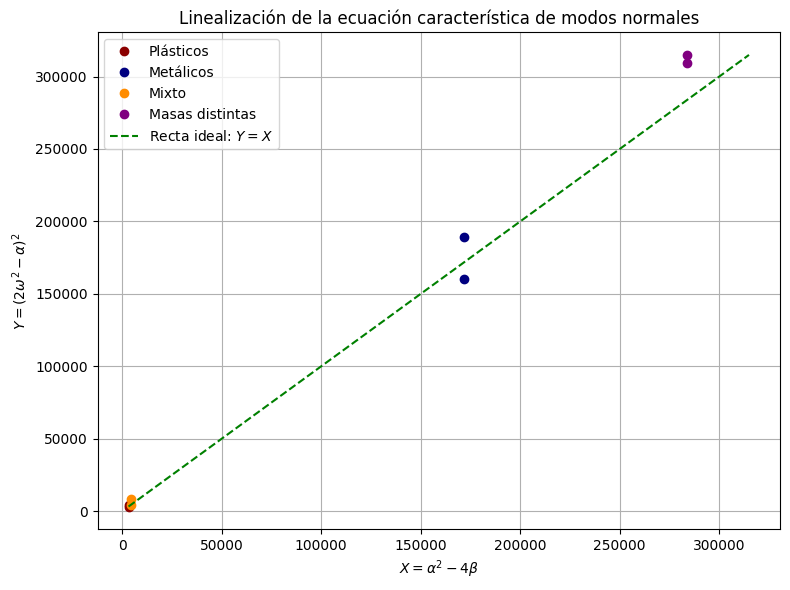

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# === Datos experimentales: cada fila es un experimento con:
# k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Exp 1 - Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Exp 2 - Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Exp 3 - Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Exp 4 - Masas distintas
])

colores = ['darkred', 'navy', 'darkorange', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

plt.figure(figsize=(8, 6))

# === Calcular alpha, beta y los puntos X, Y por experimento
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k3 * k2) / (m1 * m2)

    color = colores[i]
    etiqueta = etiquetas[i]

    for j, omega in enumerate([omega1, omega2], start=1):
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        print(f"Experimento {i+1} - ω{j}: X = {X:.3f}, Y = {Y:.3f}")
        plt.plot(X, Y, 'o', color=color, label=etiqueta)
        etiqueta = None  # Evita duplicar leyenda

# === Dibujar recta ideal Y = X
all_X = []
all_Y = []
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k3 * k2) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_X.append(X)
        all_Y.append(Y)

min_val = min(all_X + all_Y)
max_val = max(all_X + all_Y)
X_line = np.linspace(min_val, max_val, 100)
plt.plot(X_line, X_line, '--', color='green', label='Recta ideal: $Y = X$')

plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y = (2\omega^2 - \alpha)^2$')
plt.title('Linealización de la ecuación característica de modos normales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Con errores



Experimento 1 - ω1 = 5.50 rad/s
  α = 123.5666 ± 14.6227
  β = 2900.6284 ± 686.5552
  X = 3666.1935 ± 4538.8214
  Y = 3977.3973 ± 1844.4044

Experimento 1 - ω2 = 9.50 rad/s
  α = 123.5666 ± 14.6227
  β = 2900.6284 ± 686.5552
  X = 3666.1935 ± 4538.8214
  Y = 3241.4109 ± 1665.0363

Experimento 2 - ω1 = 14.40 rad/s
  α = 849.9545 ± 100.5376
  β = 137656.8770 ± 32560.5438
  X = 171795.2084 ± 214875.5128
  Y = 189429.1029 ± 87514.8994

Experimento 2 - ω2 = 25.00 rad/s
  α = 849.9545 ± 100.5376
  β = 137656.8770 ± 32560.5438
  X = 171795.2084 ± 214875.5128
  Y = 160036.3718 ± 80439.2467

Experimento 3 - ω1 = 14.26 rad/s
  α = 497.7193 ± 58.9048
  β = 60826.3443 ± 14387.7912
  X = 4419.1065 ± 82160.3689
  Y = 8285.3835 ± 10723.5049

Experimento 3 - ω2 = 16.78 rad/s
  α = 497.7193 ± 58.9048
  β = 60826.3443 ± 14387.7912
  X = 4419.1065 ± 82160.3689
  Y = 4279.4517 ± 7706.8075

Experimento 4 - ω1 = 13.96 rad/s
  α = 950.9500 ± 162.7472
  β = 155137.1748 ± 43622.4534
  X = 283757.2767 ± 355323

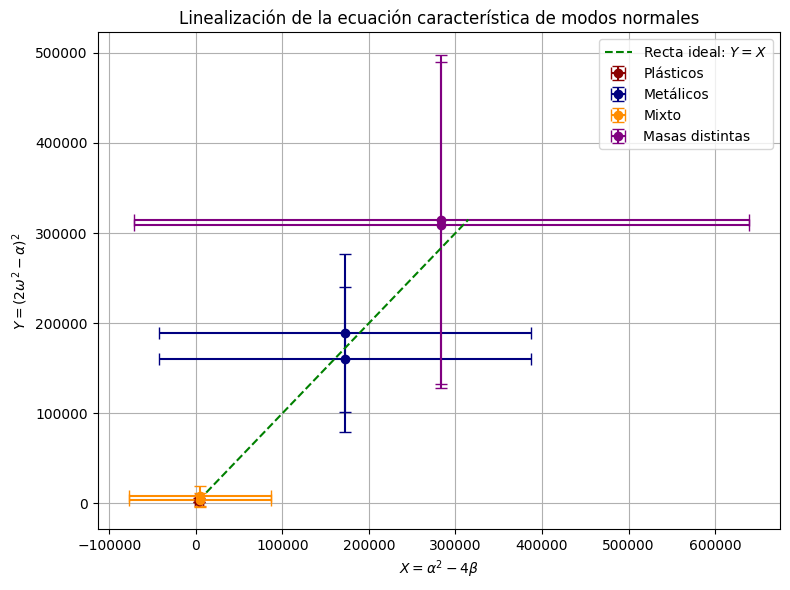

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# === Datos experimentales: cada fila es un experimento con:
# k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Exp 1 - Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Exp 2 - Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Exp 3 - Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Exp 4 - Masas distintas
])

colores = ['darkred', 'navy', 'darkorange', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

# === Incertidumbres constantes
dk1, dk2, dk3 = 0.05, 0.05, 0.1   # N/m
dm1, dm2 = 0.05, 0.05             # kg

plt.figure(figsize=(8, 6))

# === Calcular y graficar
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    color = colores[i]
    etiqueta = etiquetas[i]

    # α y β
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)

    # Derivadas parciales de α
    d_alpha_k1 = 1 / m1
    d_alpha_k2 = 1 / m1 + 1 / m2
    d_alpha_k3 = 1 / m2
    d_alpha_m1 = -(k1 + k2) / m1**2
    d_alpha_m2 = -(k2 + k3) / m2**2

    delta_alpha = np.sqrt(
        (d_alpha_k1 * dk1)**2 +
        (d_alpha_k2 * dk2)**2 +
        (d_alpha_k3 * dk3)**2 +
        (d_alpha_m1 * dm1)**2 +
        (d_alpha_m2 * dm2)**2
    )

    # Derivadas parciales de β
    d_beta_k1 = (k2 + k3) / (m1 * m2)
    d_beta_k2 = (k1 + k3) / (m1 * m2)
    d_beta_k3 = (k1 + k2) / (m1 * m2)
    d_beta_m1 = -beta / m1
    d_beta_m2 = -beta / m2

    delta_beta = np.sqrt(
        (d_beta_k1 * dk1)**2 +
        (d_beta_k2 * dk2)**2 +
        (d_beta_k3 * dk3)**2 +
        (d_beta_m1 * dm1)**2 +
        (d_beta_m2 * dm2)**2
    )

    dX_dalpha = 2 * alpha
    dX_dbeta = -4
    delta_X = np.sqrt((dX_dalpha * delta_alpha)**2 + (dX_dbeta * delta_beta)**2)

    for j, omega in enumerate([omega1, omega2], start=1):
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2

        dY_dalpha = -2 * (2 * omega_sq - alpha)
        delta_Y = abs(dY_dalpha) * delta_alpha

        # === Mostrar los valores en consola
        print(f"\nExperimento {i+1} - ω{j} = {omega:.2f} rad/s")
        print(f"  α = {alpha:.4f} ± {delta_alpha:.4f}")
        print(f"  β = {beta:.4f} ± {delta_beta:.4f}")
        print(f"  X = {X:.4f} ± {delta_X:.4f}")
        print(f"  Y = {Y:.4f} ± {delta_Y:.4f}")

        plt.errorbar(X, Y, xerr=delta_X, yerr=delta_Y,
                     fmt='o', color=color, label=etiqueta, capsize=4)
        etiqueta = None

# === Recta ideal Y = X
all_XY = []
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k3 * k2) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_XY.append(X)
        all_XY.append(Y)

min_val = min(all_XY)
max_val = max(all_XY)
X_line = np.linspace(min_val, max_val, 100)
plt.plot(X_line, X_line, '--', color='green', label='Recta ideal: $Y = X$')

plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y = (2\omega^2 - \alpha)^2$')
plt.title('Linealización de la ecuación característica de modos normales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## cone errores y normalizado

Plásticos: ω = 5.50 rad/s -> X = 0.0116, Y = 0.0126
Plásticos: ω = 9.50 rad/s -> X = 0.0116, Y = 0.0103
Metálicos: ω = 14.40 rad/s -> X = 0.5455, Y = 0.6015
Metálicos: ω = 25.00 rad/s -> X = 0.5455, Y = 0.5082
Mixto: ω = 14.26 rad/s -> X = 0.0140, Y = 0.0263
Mixto: ω = 16.78 rad/s -> X = 0.0140, Y = 0.0136
Masas distintas: ω = 13.96 rad/s -> X = 0.9010, Y = 1.0000
Masas distintas: ω = 27.45 rad/s -> X = 0.9010, Y = 0.9818


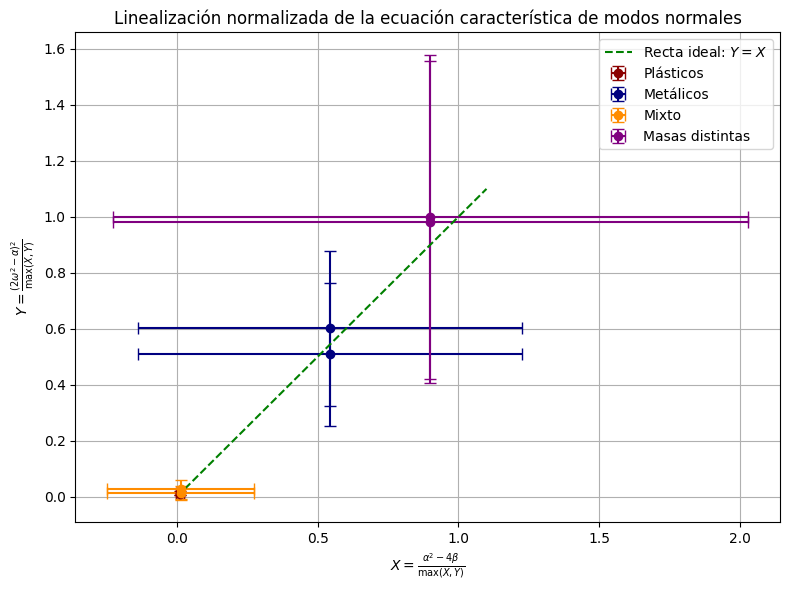

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# === Datos experimentales: k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Masas distintas
])

colores = ['darkred', 'navy', 'darkorange', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

# === Incertidumbres
dk1, dk2, dk3 = 0.05, 0.05, 0.1
dm1, dm2 = 0.05, 0.05

# === Preparar figura
plt.figure(figsize=(8, 6))

# === Recolectar todos los X, Y para normalizar
all_X = []
all_Y = []

# === Preprocesar para encontrar escala de normalización
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_X.append(X)
        all_Y.append(Y)

escala = max(max(all_X), max(all_Y))  # Normalización global

# === Calcular y graficar
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    color = colores[i]
    etiqueta = etiquetas[i]

    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)

    # Derivadas parciales para error de α
    d_alpha_k1 = 1 / m1
    d_alpha_k2 = 1 / m1 + 1 / m2
    d_alpha_k3 = 1 / m2
    d_alpha_m1 = -(k1 + k2) / m1**2
    d_alpha_m2 = -(k2 + k3) / m2**2

    delta_alpha = np.sqrt(
        (d_alpha_k1 * dk1)**2 +
        (d_alpha_k2 * dk2)**2 +
        (d_alpha_k3 * dk3)**2 +
        (d_alpha_m1 * dm1)**2 +
        (d_alpha_m2 * dm2)**2
    )

    # Derivadas parciales para error de β
    d_beta_k1 = (k2 + k3) / (m1 * m2)
    d_beta_k2 = (k1 + k3) / (m1 * m2)
    d_beta_k3 = (k1 + k2) / (m1 * m2)
    d_beta_m1 = -beta / m1
    d_beta_m2 = -beta / m2

    delta_beta = np.sqrt(
        (d_beta_k1 * dk1)**2 +
        (d_beta_k2 * dk2)**2 +
        (d_beta_k3 * dk3)**2 +
        (d_beta_m1 * dm1)**2 +
        (d_beta_m2 * dm2)**2
    )

    # Derivadas para X = α² - 4β
    dX_dalpha = 2 * alpha
    dX_dbeta = -4
    delta_X = np.sqrt((dX_dalpha * delta_alpha)**2 + (dX_dbeta * delta_beta)**2)

    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = (alpha**2 - 4 * beta) / escala
        Y = ((2 * omega_sq - alpha)**2) / escala

        dY_dalpha = -2 * (2 * omega_sq - alpha)
        delta_Y = abs(dY_dalpha) * delta_alpha / escala
        delta_X_norm = delta_X / escala

        plt.errorbar(X, Y, xerr=delta_X_norm, yerr=delta_Y,
                     fmt='o', color=color, label=etiqueta, capsize=4)
        print(f"{etiquetas[i]}: ω = {omega:.2f} rad/s -> X = {X:.4f}, Y = {Y:.4f}")
        etiqueta = None

# === Recta ideal Y = X normalizada
X_line = np.linspace(0, 1.1, 100)
plt.plot(X_line, X_line, '--', color='green', label='Recta ideal: $Y = X$')

# === Gráfico final
plt.xlabel(r'$X = \frac{\alpha^2 - 4\beta}{\max(X,Y)}$')
plt.ylabel(r'$Y = \frac{(2\omega^2 - \alpha)^2}{\max(X,Y)}$')
plt.title('Linealización normalizada de la ecuación característica de modos normales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Experimento 1 - ω1: X = 0.0116, Y = 0.0126
Experimento 1 - ω2: X = 0.0116, Y = 0.0103
Experimento 2 - ω1: X = 0.5455, Y = 0.6015
Experimento 2 - ω2: X = 0.5455, Y = 0.5082
Experimento 3 - ω1: X = 0.0140, Y = 0.0263
Experimento 3 - ω2: X = 0.0140, Y = 0.0136
Experimento 4 - ω1: X = 0.9010, Y = 1.0000
Experimento 4 - ω2: X = 0.9010, Y = 0.9818


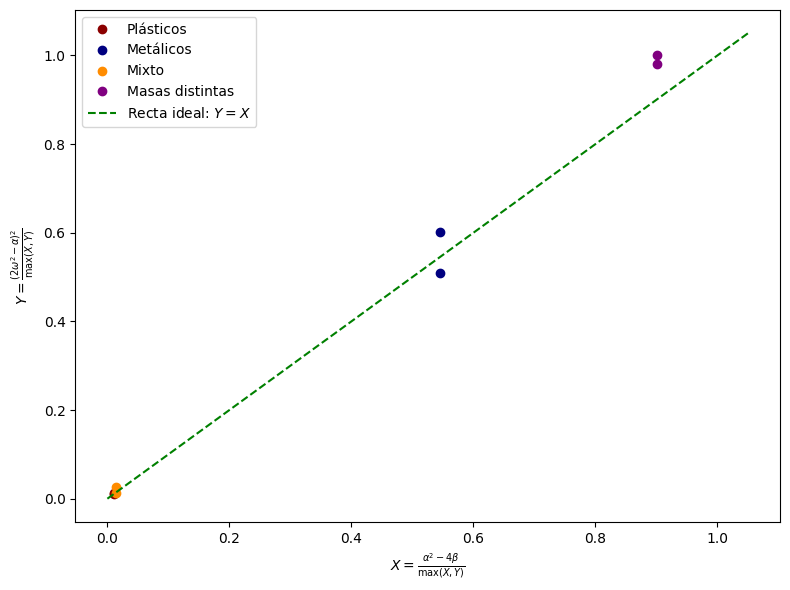

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# === Datos experimentales: cada fila es un experimento con:
# k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Exp 1 - Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Exp 2 - Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Exp 3 - Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Exp 4 - Masas distintas
])

colores = ['darkred', 'navy', 'darkorange', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

plt.figure(figsize=(8, 6))

# === Calcular todos los X, Y para normalización
all_X = []
all_Y = []
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_X.append(X)
        all_Y.append(Y)

# === Escala de normalización
escala = max(max(all_X), max(all_Y))

# === Graficar puntos normalizados
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)

    color = colores[i]
    etiqueta = etiquetas[i]

    for j, omega in enumerate([omega1, omega2], start=1):
        omega_sq = omega**2
        X = (alpha**2 - 4 * beta) / escala
        Y = ((2 * omega_sq - alpha)**2) / escala
        print(f"Experimento {i+1} - ω{j}: X = {X:.4f}, Y = {Y:.4f}")
        plt.plot(X, Y, 'o', color=color, label=etiqueta)
        etiqueta = None  # Evita duplicar leyenda

# === Recta ideal Y = X normalizada
X_line = np.linspace(0, 1.05, 100)
plt.plot(X_line, X_line, '--', color='green', label='Recta ideal: $Y = X$')

# === Etiquetas y formato
plt.xlabel(r'$X = \frac{\alpha^2 - 4\beta}{\max(X,Y)}$')
plt.ylabel(r'$Y = \frac{(2\omega^2 - \alpha)^2}{\max(X,Y)}$')
plt.legend()
plt.tight_layout()
plt.show()

Experimento 1 - ω1: X = 0.0116, Y = 0.0126
Experimento 1 - ω2: X = 0.0116, Y = 0.0103
Experimento 2 - ω1: X = 0.5455, Y = 0.6015
Experimento 2 - ω2: X = 0.5455, Y = 0.5082
Experimento 3 - ω1: X = 0.0140, Y = 0.0263
Experimento 3 - ω2: X = 0.0140, Y = 0.0136
Experimento 4 - ω1: X = 0.9010, Y = 1.0000
Experimento 4 - ω2: X = 0.9010, Y = 0.9818


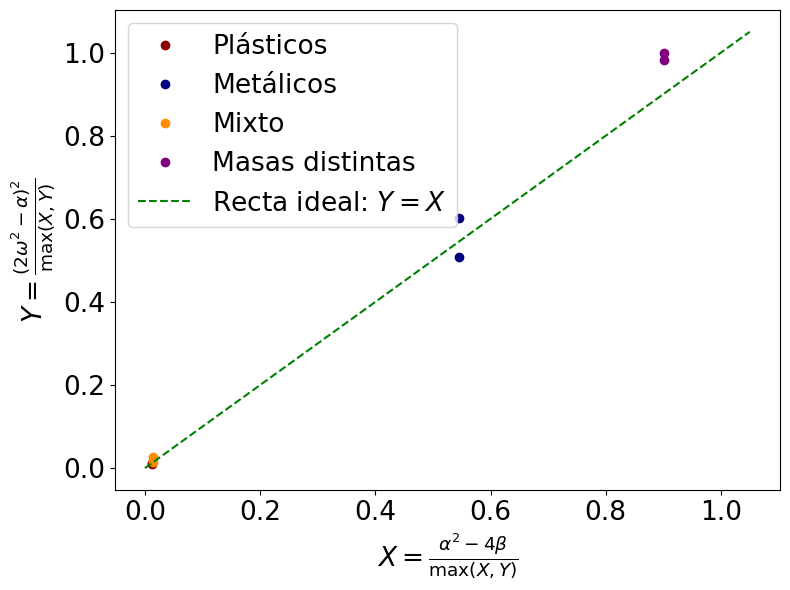

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# === Tamaño de fuente configurable ===
Fsize = 19  # Podés cambiar este valor libremente

# === Datos experimentales: cada fila es un experimento con:
# k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Exp 1 - Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Exp 2 - Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Exp 3 - Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Exp 4 - Masas distintas
])

colores = ['darkred', 'navy', 'darkorange', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

plt.figure(figsize=(8, 6))

# === Calcular todos los X, Y para normalización
all_X = []
all_Y = []
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_X.append(X)
        all_Y.append(Y)

# === Escala de normalización
escala = max(max(all_X), max(all_Y))

# === Graficar puntos normalizados
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)

    color = colores[i]
    etiqueta = etiquetas[i]

    for j, omega in enumerate([omega1, omega2], start=1):
        omega_sq = omega**2
        X = (alpha**2 - 4 * beta) / escala
        Y = ((2 * omega_sq - alpha)**2) / escala
        print(f"Experimento {i+1} - ω{j}: X = {X:.4f}, Y = {Y:.4f}")
        plt.plot(X, Y, 'o', color=color, label=etiqueta)
        etiqueta = None  # Evita duplicar leyenda

# === Recta ideal Y = X normalizada
X_line = np.linspace(0, 1.05, 100)
plt.plot(X_line, X_line, '--', color='green', label='Recta ideal: $Y = X$')

# === Etiquetas y formato
plt.xlabel(r'$X = \frac{\alpha^2 - 4\beta}{\max(X,Y)}$', fontsize=Fsize)
plt.ylabel(r'$Y = \frac{(2\omega^2 - \alpha)^2}{\max(X,Y)}$', fontsize=Fsize)
plt.legend(fontsize=Fsize)
plt.xticks(fontsize=Fsize)
plt.yticks(fontsize=Fsize)
plt.tight_layout()
plt.show()

Experimento 1 - ω1: X = 3666.194, Y = 3977.397
Experimento 1 - ω2: X = 3666.194, Y = 3241.411
Experimento 2 - ω1: X = 171795.208, Y = 189429.103
Experimento 2 - ω2: X = 171795.208, Y = 160036.372
Experimento 3 - ω1: X = 4419.107, Y = 8285.384
Experimento 3 - ω2: X = 4419.107, Y = 4279.452
Experimento 4 - ω1: X = 283757.277, Y = 314930.668
Experimento 4 - ω2: X = 283757.277, Y = 309197.120


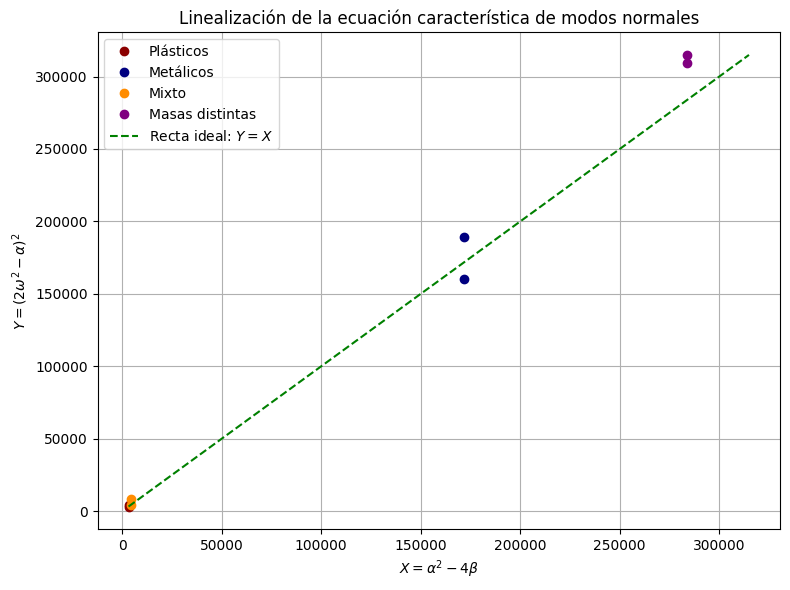

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# === Datos experimentales: cada fila es un experimento con:
# k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Exp 1 - Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Exp 2 - Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Exp 3 - Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Exp 4 - Masas distintas
])

colores = ['darkred', 'navy', 'darkorange', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

plt.figure(figsize=(8, 6))

# === Calcular alpha, beta y los puntos X, Y por experimento
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k3 * k2) / (m1 * m2)

    color = colores[i]
    etiqueta = etiquetas[i]

    for j, omega in enumerate([omega1, omega2], start=1):
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        print(f"Experimento {i+1} - ω{j}: X = {X:.3f}, Y = {Y:.3f}")
        plt.plot(X, Y, 'o', color=color, label=etiqueta)
        etiqueta = None  # Evita duplicar leyenda

# === Dibujar recta ideal Y = X
all_X = []
all_Y = []
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k3 * k2) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_X.append(X)
        all_Y.append(Y)

min_val = min(all_X + all_Y)
max_val = max(all_X + all_Y)
X_line = np.linspace(min_val, max_val, 100)
plt.plot(X_line, X_line, '--', color='green', label='Recta ideal: $Y = X$')

plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y = (2\omega^2 - \alpha)^2$')
plt.title('Linealización de la ecuación característica de modos normales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Experimento 1 - ω1: X = 0.0116, Y = 0.0126
Experimento 1 - ω2: X = 0.0116, Y = 0.0103
Experimento 2 - ω1: X = 0.5455, Y = 0.6015
Experimento 2 - ω2: X = 0.5455, Y = 0.5082
Experimento 3 - ω1: X = 0.0140, Y = 0.0263
Experimento 3 - ω2: X = 0.0140, Y = 0.0136
Experimento 4 - ω1: X = 0.9010, Y = 1.0000
Experimento 4 - ω2: X = 0.9010, Y = 0.9818


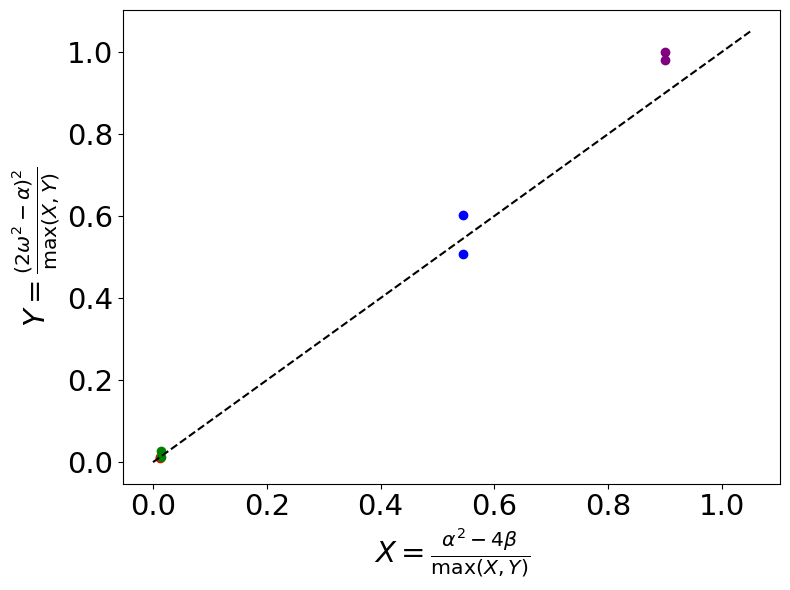

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# === Tamaño de fuente configurable ===
Fsize = 21 # Podés cambiar este valor libremente

# === Datos experimentales: cada fila es un experimento con:
# k1, k2, k3, m1, m2, omega1, omega2
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],         # Exp 1 - Plásticos
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],      # Exp 2 - Metálicos
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],     # Exp 3 - Mixto
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],    # Exp 4 - Masas distintas
])

colores = ['red', 'blue', 'green', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']

plt.figure(figsize=(8, 6))

# === Calcular todos los X, Y para normalización
all_X = []
all_Y = []
for k1, k2, k3, m1, m2, omega1, omega2 in datos:
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)
    for omega in [omega1, omega2]:
        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2
        all_X.append(X)
        all_Y.append(Y)

# === Escala de normalización
escala = max(max(all_X), max(all_Y))

# === Graficar puntos normalizados
for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)

    color = colores[i]
    etiqueta = etiquetas[i]

    for j, omega in enumerate([omega1, omega2], start=1):
        omega_sq = omega**2
        X = (alpha**2 - 4 * beta) / escala
        Y = ((2 * omega_sq - alpha)**2) / escala
        print(f"Experimento {i+1} - ω{j}: X = {X:.4f}, Y = {Y:.4f}")
        plt.plot(X, Y, 'o', color=color, label=etiqueta)
        etiqueta = None  # Evita duplicar leyenda

# === Recta ideal Y = X normalizada
X_line = np.linspace(0, 1.05, 100)
plt.plot(X_line, X_line, '--', color='black', label='Recta ideal: $Y = X$')

# === Etiquetas y formato
plt.xlabel(r'$X = \frac{\alpha^2 - 4\beta}{\max(X,Y)}$', fontsize=Fsize)
plt.ylabel(r'$Y = \frac{(2\omega^2 - \alpha)^2}{\max(X,Y)}$', fontsize=Fsize)
plt.xticks(fontsize=Fsize)
plt.yticks(fontsize=Fsize)
plt.tight_layout()
plt.show()